In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
import subprocess
from scipy.optimize import curve_fit

## Load Data and display tabke

In [2]:
df = pd.read_excel('Hg.xlsx')
df

,order,direction,lambda,degree eyepiece,arcminute eyepiece,degree inlet,arcminute inlet,uncertainty,zero
0,1,1,404.66,14,3,194,2,1,1.5
1,1,1,435.84,15,10,195,8,1,1.5
2,1,1,576.96,20,14,200,13,1,1.5
3,1,1,578.97,20,18,200,18,1,1.5
4,2,1,435.84,31,31,211,30,1,1.5
5,2,1,546.07,40,55,220,55,1,1.5
6,2,1,576.96,43,48,223,48,1,1.5
7,3,1,435.84,51,40,231,36,1,1.5
8,1,-1,404.66,345,58,165,55,1,1.5
9,1,-1,435.84,344,50,164,48,1,1.5


## Send table to an array and transpose it for easy indexing, then pull out all the necessary attributes

In [3]:
arr = df.values.T
eye_d = arr[3]
eye_m = arr[4]
in_d = arr[5]
in_m = arr[6]
orders = arr[0]
lambdas = arr[2]
directions = arr[1]
zero = 0*arr[8]
uncertainties = arr[7]

## Add the zero to the minutes and then convert to degrees from arcminutes

In [4]:
eye_m += zero*directions
in_m += zero*directions
eye_m = eye_m/60
in_m = in_m/60

## Add the converted arcminutes to the degrees

In [5]:
eye_d += eye_m
in_d += in_m

## Find the differences and average the readings from both verniers output which measurements need to be reconsidered

In [6]:
diff = eye_d - (in_d-180)%360
bools = diff>10**(-6)
print('there are {} measurements to recheck, check the arrays for the wavelength and order'.format(np.sum(bools)))
wl = lambdas[bools]
order = orders[bools]
direction = directions[bools]
print(wl)
print(order)
print(direction)
print(eye_d[bools], (in_d[bools]-180)%360)
# for indexing the fit
indices = np.invert(bools)

there are 14 measurements to recheck, check the arrays for the wavelength and order
[404.66 435.84 576.96 435.84 435.84 404.66 435.84 546.07 576.96 578.97
 435.84 546.07 576.96 435.84]
[1. 1. 1. 2. 3. 1. 1. 1. 1. 1. 2. 2. 2. 3.]
[ 1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[ 14.05        15.16666667  20.23333333  31.51666667  51.66666667
 345.96666667 344.83333333 340.88333333 339.75       339.66666667
 328.5        319.08333333 316.2        308.33333333] [ 14.03333333  15.13333333  20.21666667  31.5         51.6
 345.91666667 344.8        340.83333333 339.7        339.61666667
 328.45       319.03333333 316.15       308.31666667]


In [7]:
average = (eye_d + (in_d-180)%360)/2
average[average>178] -= 360
print(np.deg2rad(average))

[ 0.24507332  0.26441738  0.35299284  0.35430184  0.54992416  0.71413055
  0.76445421  0.90117167 -0.2453642  -0.26499916 -0.33408511 -0.35386551
 -0.35531995 -0.55021505 -0.71456688 -0.76489054 -0.90189889]


## Now we do a least squares fit given by the following equation

$$ n_k\lambda_k = d(\sin\theta_i \pm \sin(\theta_k\pm\theta_i)) $$

## To determine $d^{-1}$ and $sin\theta_i$

In [8]:
def f(x, d, thi):
    # could be + or - for where these are
    return d*(np.sin(thi)+np.sin(x-thi))

def f_err(x,d,thi,xerr,derr,thierr):
    return (d*np.cos(x-thi)*xerr)**2 + ((np.sin(thi)+np.sin(x-thi))*derr)**2 + (d*(np.cos(thi)-np.cos(x-thi))*thierr)**2

def chi_squared(exp, th, err):
    if len(exp) != len(th):
        raise ValueError('dimensions do not match')
        
    return {'theoretical_chi_2':len(exp), 'chi2_deviation':np.sqrt(2*len(exp)), 'calculated_chi2':np.sum((exp-th)**2/err)}

<ErrorbarContainer object of 3 artists>

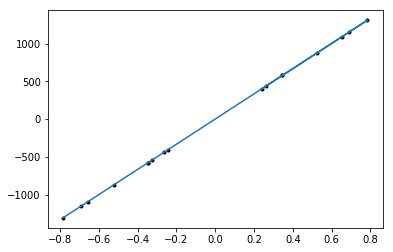

In [9]:
outs = lambdas*orders*directions
ins = np.deg2rad(average)
init = [1/600*10**(6), 0.01]
params, cov = curve_fit(f, ins, outs, p0=init)

d = params[0]
derr = np.sqrt(cov[0,0])
thierr = np.sqrt(cov[1,1])
thi = params[1]
xerr = np.deg2rad(1/60)

err = f_err(ins,d,thi,xerr,derr,thierr)
plt.plot(np.sin(ins), outs, 'k.')
plt.errorbar(np.sin(ins), f(ins, d, thi), yerr=np.sqrt(err))

<ErrorbarContainer object of 3 artists>

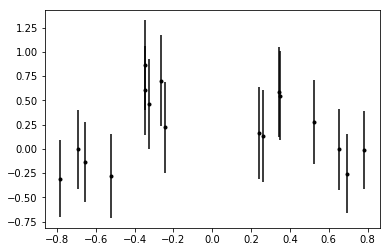

In [10]:
plt.errorbar(np.sin(ins), outs-f(ins,d,thi), yerr=np.sqrt(err), fmt='.k')

In [11]:
chi2 = chi_squared(outs, f(ins,d,thi), err)
print(chi2)

{'theoretical_chi_2': 17, 'chi2_deviation': 5.830951894845301, 'calculated_chi2': 13.781354818953918}


<ErrorbarContainer object of 3 artists>

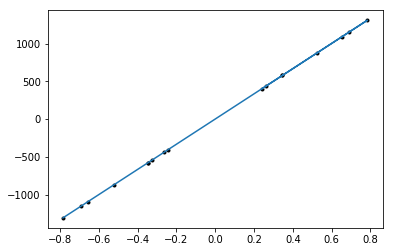

In [12]:
outs = lambdas*orders*directions
ins = np.deg2rad(average)
init = [1/600*10**(6), 0.01]
params, cov = curve_fit(f, ins, outs, p0=init, sigma=1/err)

d = params[0]
derr = np.sqrt(cov[0,0])
thierr = np.sqrt(cov[1,1])
thi = params[1]
xerr = np.deg2rad(1/60)

err = f_err(ins,d,thi,xerr,derr,thierr)
plt.plot(np.sin(ins), outs, 'k.')
plt.errorbar(np.sin(ins), f(ins, d, thi), yerr=np.sqrt(err))

Text(0.5, 0, '$\\sin\\theta$')

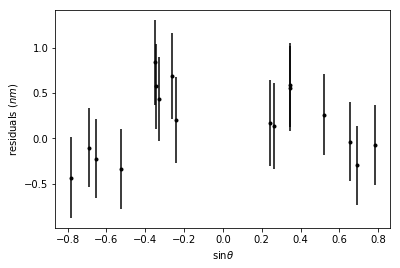

In [13]:
plt.errorbar(np.sin(ins), outs-f(ins,d,thi), yerr=np.sqrt(err), fmt='.k')
plt.ylabel(r'residuals $(nm)$')
plt.xlabel(r'$\sin\theta$')
#plt.savefig('bad_residuals.png')

In [14]:
chi2 = chi_squared(outs, f(ins,d,thi), err)
print(chi2)

{'theoretical_chi_2': 17, 'chi2_deviation': 5.830951894845301, 'calculated_chi2': 13.786314503312072}


In [15]:
df = pd.read_excel('Hydrogen.xlsx')
df

,order,orientation,lambda,degree eyepiece,arcminute eyepiece,degree inlet,arcminute inlet,uncertainty,zero
0,1,1,434.05,15,4,195,3,1,1.5
1,1,1,486.13,16,55,196,53,1,1.5
2,1,1,656.30,23,10,203,7,1,1.5
3,2,1,434.05,31,20,211,17,1,1.5
4,2,1,486.13,35,40,215,36,1,1.5
5,2,1,656.30,51,57,231,53,1,1.5
6,1,-1,434.05,344,55,154,51,1,1.5
7,1,-1,486.13,343,2,162,58,1,1.5
8,1,-1,656.30,336,48,156,43,1,1.5
9,2,-1,434.05,328,37,148,33,1,1.5


In [16]:
arr = df.values.T
eye_d = arr[3]
eye_m = arr[4]
in_d = arr[5]
in_m = arr[6]
orders = arr[0]
lambdas = arr[2]
directions = arr[1]
zero = 0*arr[8]
uncertainties = arr[7]

In [17]:
eye_m += zero*directions
in_m += zero*directions
eye_m = eye_m/60
in_m = in_m/60

In [18]:
eye_d += eye_m
in_d += in_m

In [19]:
diff = eye_d - (in_d-180)%360
bools = diff>10**(-6)
print('there are {} measurements to recheck, check the arrays for the wavelength and order'.format(np.sum(bools)))
wl = lambdas[bools]
order = orders[bools]
direction = directions[bools]
print(wl)
print(order)
print(direction)
print(eye_d[bools], (in_d[bools]-180)%360)
# for indexing the fit
indices = np.invert(bools)

there are 12 measurements to recheck, check the arrays for the wavelength and order
[434.05 486.13 656.3  434.05 486.13 656.3  434.05 486.13 656.3  434.05
 486.13 656.3 ]
[1. 1. 1. 2. 2. 2. 1. 1. 1. 2. 2. 2.]
[ 1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.]
[ 15.06666667  16.91666667  23.16666667  31.33333333  35.66666667
  51.95       344.91666667 343.03333333 336.8        328.61666667
 324.3        308.08333333] [ 15.05        16.88333333  23.11666667  31.28333333  35.6
  51.88333333 334.85       342.96666667 336.71666667 328.55
 324.2        308.        ]


In [20]:
average = (eye_d + (in_d-180)%360)/2
average[average>178] -= 360
print(np.deg2rad(average))

[ 0.2628175   0.29496064  0.40389828  0.5464335   0.62191899  0.90611677
 -0.35110207 -0.29670597 -0.40564361 -0.54832427 -0.62395521 -0.90684399]


In [21]:
ins = np.deg2rad(average)

wls = f(ins, d, thi)/orders
print(wls)
wl_uncertainties = np.sqrt(f_err(ins,d,thi,xerr,derr,thierr))
print(wl_uncertainties)

[ 433.12888192  484.65139439  655.24607931  433.2247062   485.72779842
  656.348655   -573.21103536 -487.29083455 -657.65335597 -434.32899517
 -486.79586775 -656.08887824]
[0.47322941 0.47042264 0.45960903 0.44493815 0.43860072 0.44297858
 0.46475888 0.47000922 0.45911513 0.44443566 0.43815905 0.44312573]


In [22]:
data_dict = {'orders':orders, 'theoretical wavelengths':lambdas,'experimental wavelengths':wls, 'uncertainties':wl_uncertainties}

In [23]:
hydrogen = pd.DataFrame(data_dict)

In [24]:
hydrogen

,orders,theoretical wavelengths,experimental wavelengths,uncertainties
0,1.0,434.05,433.128882,0.473229
1,1.0,486.13,484.651394,0.470423
2,1.0,656.30,655.246079,0.459609
3,2.0,434.05,433.224706,0.444938
4,2.0,486.13,485.727798,0.438601
5,2.0,656.30,656.348655,0.442979
6,1.0,434.05,-573.211035,0.464759
7,1.0,486.13,-487.290835,0.470009
8,1.0,656.30,-657.653356,0.459115
9,2.0,434.05,-434.328995,0.444436
